In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import cv2

from cifar import CifarDataset

%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
dataset = CifarDataset('./data/cifar-10-batches-py', device)
test_dataset, val_dataset = torch.utils.data.random_split(TensorDataset(dataset.test_x, dataset.test_y), [5000, 5000])
print("training samples: %d" % len(dataset))
print("validation samples: %d" % len(val_dataset))
print("test samples: %d" % len(test_dataset))

training samples: 50000
validation samples: 5000
test samples: 5000


In [3]:
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [14]:
model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.Dropout2d(0.25),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(128, 64, kernel_size=3, padding=1),
    nn.Dropout2d(0.25),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64*4*4, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 10)
).to(device)
lossfn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', verbose=True,
    factor=0.2, patience=5, threshold=1e-3, threshold_mode='rel', min_lr=5e-6)

In [15]:
from torchsummary import summary
summary(model, torch.zeros(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─ReLU: 1-3                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Conv2d: 1-5                            [-1, 128, 16, 16]         73,856
├─Dropout2d: 1-6                         [-1, 128, 16, 16]         --
├─BatchNorm2d: 1-7                       [-1, 128, 16, 16]         256
├─ReLU: 1-8                              [-1, 128, 16, 16]         --
├─MaxPool2d: 1-9                         [-1, 128, 8, 8]           --
├─Conv2d: 1-10                           [-1, 64, 8, 8]            73,792
├─Dropout2d: 1-11                        [-1, 64, 8, 8]            --
├─BatchNorm2d: 1-12                      [-1, 64, 8, 8]            128
├─ReLU: 1-13                             [-1, 64, 8, 8]            --
├

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─BatchNorm2d: 1-2                       [-1, 64, 32, 32]          128
├─ReLU: 1-3                              [-1, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [-1, 64, 16, 16]          --
├─Conv2d: 1-5                            [-1, 128, 16, 16]         73,856
├─Dropout2d: 1-6                         [-1, 128, 16, 16]         --
├─BatchNorm2d: 1-7                       [-1, 128, 16, 16]         256
├─ReLU: 1-8                              [-1, 128, 16, 16]         --
├─MaxPool2d: 1-9                         [-1, 128, 8, 8]           --
├─Conv2d: 1-10                           [-1, 64, 8, 8]            73,792
├─Dropout2d: 1-11                        [-1, 64, 8, 8]            --
├─BatchNorm2d: 1-12                      [-1, 64, 8, 8]            128
├─ReLU: 1-13                             [-1, 64, 8, 8]            --
├

In [16]:
def train_batch(x, y, model, lossfn, opt):
    model.train()
    yp = model(x)
    loss = lossfn(yp, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

@torch.no_grad()
def val_loss(x, y, model, lossfn):
    model.eval()
    yp = model(x)
    loss = lossfn(yp, y)
    return loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    yp = model(x).argmax(dim=1)
    is_correct = (y == yp).cpu().numpy().tolist()
    return is_correct

In [17]:
import time
train_losses = []
val_losses = []
val_acces = []

for epoch in range(50):
    start = time.time()

    # training
    epoch_train_losses = []
    for x, y in train_loader:
        loss = train_batch(x, y, model, lossfn, optimizer)
        epoch_train_losses.append(loss)
    epoch_train_loss = np.mean(epoch_train_losses)
    train_losses.append(epoch_train_loss)

    epoch_val_losses = []
    epoch_val_acces = []
    for x, y in val_loader:
        loss = val_loss(x, y, model, lossfn)
        epoch_val_losses.append(loss)
        is_correct = accuracy(x, y, model)
        epoch_val_acces.extend(is_correct)
    epoch_val_loss = np.mean(epoch_val_losses)
    val_losses.append(epoch_val_loss)
    epoch_val_acc = np.mean(epoch_val_acces)
    val_acces.append(epoch_val_acc)
    scheduler.step(epoch_val_loss)

    end = time.time()
    print("epoch %d, %.2fs, trloss: %.2f, valloss: %.2f, valcc: %.2f" %
          (epoch, end-start, epoch_train_loss, epoch_val_loss, epoch_val_acc*100))

test_acces = []
for x, y in test_loader:
    is_correct = accuracy(x, y, model)
    test_acces.extend(is_correct)
test_acc = np.mean(test_acces)
print("======================")
print("final test acc %.2f" % (test_acc*100))
print("======================")


epoch 0, 10.78s, trloss: 2.05, valloss: 1.85, valcc: 33.22
epoch 1, 10.71s, trloss: 1.78, valloss: 1.67, valcc: 39.58
epoch 2, 10.80s, trloss: 1.64, valloss: 1.56, valcc: 43.22
epoch 3, 10.82s, trloss: 1.55, valloss: 1.48, valcc: 46.42
epoch 4, 10.90s, trloss: 1.48, valloss: 1.39, valcc: 50.10
epoch 5, 10.75s, trloss: 1.42, valloss: 1.34, valcc: 51.62
epoch 6, 10.57s, trloss: 1.36, valloss: 1.30, valcc: 53.08
epoch 7, 10.73s, trloss: 1.31, valloss: 1.26, valcc: 54.34
epoch 8, 10.67s, trloss: 1.27, valloss: 1.31, valcc: 52.94
epoch 9, 10.69s, trloss: 1.23, valloss: 1.17, valcc: 58.34
epoch 10, 10.74s, trloss: 1.19, valloss: 1.46, valcc: 49.50
epoch 11, 10.71s, trloss: 1.15, valloss: 1.11, valcc: 61.18
epoch 12, 10.73s, trloss: 1.13, valloss: 1.94, valcc: 40.42
epoch 13, 10.65s, trloss: 1.10, valloss: 1.28, valcc: 56.50
epoch 14, 10.83s, trloss: 1.07, valloss: 1.05, valcc: 63.30
epoch 15, 10.65s, trloss: 1.05, valloss: 1.03, valcc: 64.56
epoch 16, 10.67s, trloss: 1.03, valloss: 1.40, val

KeyboardInterrupt: 

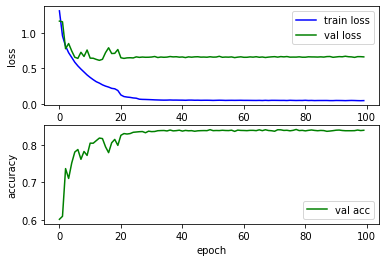

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(train_losses, 'b', label='train loss')
plt.plot(val_losses, 'g', label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(val_acces, 'g', label='val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()